#  Прогнозирование заказов такси

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Постройте модель для такого предсказания.

Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

Вам нужно:

1. Загрузить данные и выполнить их ресемплирование по одному часу.
2. Проанализировать данные.
3. Обучить разные модели с различными гиперпараметрами. Сделать тестовую выборку размером 10% от исходных данных.
4. Проверить данные на тестовой выборке и сделать выводы.

## Подготовка

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler 
from catboost import CatBoostRegressor
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV

Загрузить данные и выполнить их ресемплирование по одному часу:

In [2]:
data = pd.read_csv('/datasets/taxi.csv', index_col=[0], parse_dates=[0])
data.info()
data.sort_index(inplace=True)
data = data['2018-03' : '2018-08'].resample('1H').sum()
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
num_orders    26496 non-null int64
dtypes: int64(1)
memory usage: 414.0 KB
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4416 entries, 2018-03-01 00:00:00 to 2018-08-31 23:00:00
Freq: H
Data columns (total 1 columns):
num_orders    4416 non-null int64
dtypes: int64(1)
memory usage: 69.0 KB


## Вывод

В данном шаге я загрузил данные, ресемплировал их по 1 часу, в итоге из 26.5 тысяч строк осталось 4.5 тысячи, также в качестве индексов использовал столбец с датами.

## Анализ

Выполняю проверку на монотонность:

In [3]:
data.index.is_monotonic

True

Строю график распределения заказов по часам и скользящего среднего:

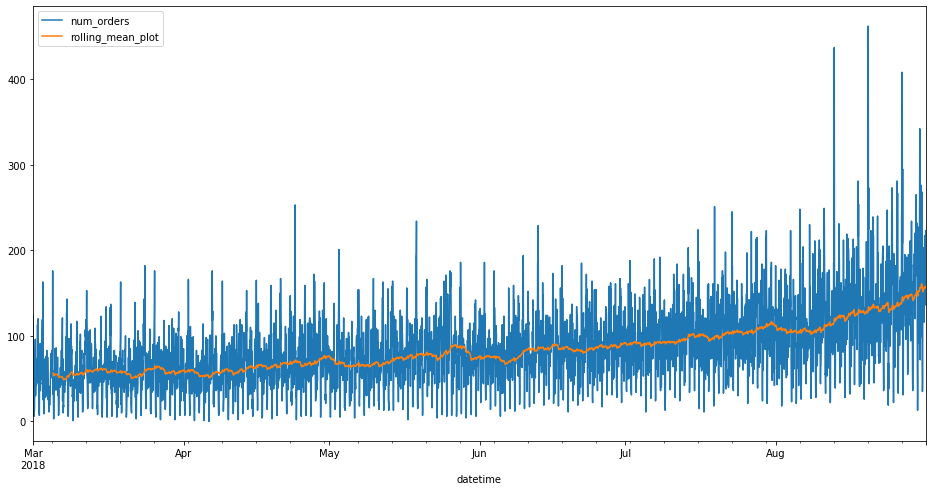

In [4]:
data['rolling_mean_plot'] = data.rolling(100).mean()
data.plot(figsize=[16,8])
plt.show()

Видно, что временной ряд изменяется не сильно, так что можно назвать его стационарным.

Далее мне интересно посмотреть на сезонность, для этого выберу промежуток в 2 дня:

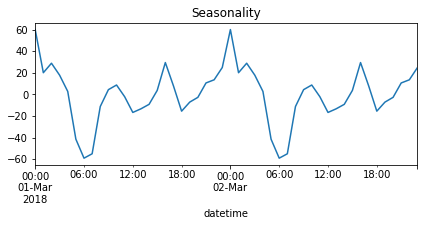

In [5]:
decomposed = seasonal_decompose(data['num_orders'])

plt.figure(figsize=(6, 8))
plt.subplot(312)
decomposed.seasonal['2018-03-01' : '2018-03-02'].plot(ax=plt.gca()) # < напишите код здесь >
plt.title('Seasonality')
plt.tight_layout()

Видно, что цикличность у нас встречается с шагом в 1 сутки.

Далее посмотрю на скользящее стандартное отклонение:

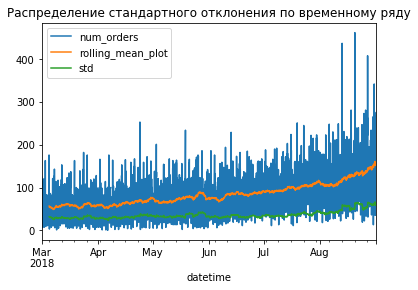

In [6]:
data['std'] = data['num_orders'].rolling(100).std()
data.plot()
plt.title('Распределение стандартного отклонения по временному ряду')
plt.show()

Видно, что стандартное отклонение также почти не меняется.

## Вывод

В данном шаге я хотел убедиться, что временной ряд стационарный и для этого использовал скользящее среднее и скользящее стандартное отклонение. Также посмотрел на сезонность и увидел, что шаг цикличности равен одним суткам.

## Обучение

Создаю признаки:

Календарные - month, day, dayofweek, hour

Отстающие значения - max_lag

Скользящее среднее - rolling_mean

In [7]:
def make_features(data, max_lag, rolling_mean_size):
    data['month'] = data.index.month
    data['day'] = data.index.day
    data['dayofweek'] = data.index.dayofweek
    data['hour'] = data.index.hour
    
    for lag in range(1, max_lag + 1):
        data['lag_{}'.format(lag)] = data['num_orders'].shift(lag)

    data['rolling_mean'] = data['num_orders'].shift().rolling(rolling_mean_size).mean()


make_features(data, 1, 30)

Разбиваю выборку на train и test в соотношении 9 к 1:

In [8]:
train, test = train_test_split(data, shuffle=False, test_size=0.1)
train = train.dropna()

features_train = train.drop(['num_orders', 'rolling_mean_plot', 'std'],axis=1)
target_train = train['num_orders']
features_test = test.drop(['num_orders', 'rolling_mean_plot', 'std'],axis=1)
target_test = test['num_orders']

Выполняю масштабирование признаков:

In [9]:
column_name = data.columns
numeric = column_name.drop(['num_orders', 'rolling_mean_plot', 'std'])

scaler = StandardScaler()
scaler.fit(features_train[numeric])
features_train[numeric] = scaler.transform(features_train[numeric])
features_test[numeric] = scaler.transform(features_test[numeric])

Подбираю гридсёрчем гиперпараметры для модели дерева решений:

In [10]:
gridParams = {'max_depth' : range(23, 25)}
tscv = TimeSeriesSplit(n_splits=5)
model_tree = DecisionTreeRegressor(random_state=12345)
grid = GridSearchCV(model_tree, gridParams, cv=tscv, scoring='neg_mean_squared_error')
grid.fit(features_train, target_train)
print(grid.best_params_)

{'max_depth': 24}


Подбираю гридсёрчем гиперпараметры для модели CatBoost:

In [11]:
model_CatBoost = CatBoostRegressor(loss_function='RMSE', random_seed=12345, learning_rate=0.1, iterations=200, l2_leaf_reg=2)

grid = {'depth': range(6,8)}

grid_search_result = model_CatBoost.grid_search(grid, 
                                       X=features_train, 
                                       y=target_train,
                                       verbose = 100,
                                       shuffle=False,
                                       cv=tscv)

grid_search_result['params']

0:	loss: 35.3061197	best: 35.3061197 (0)	total: 6.49s	remaining: 6.49s
1:	loss: 36.7658448	best: 35.3061197 (0)	total: 12.7s	remaining: 0us
Estimating final quality...


{'depth': 6}

## Вывод

В данном шаге я добавил в датасет признаков, разбил на выборки, масштабировал признаки и подобрал гиперпараметры для моделей дерева решений и CatBoost.

Но есть вопрос - можно ли у GridSearchCV и grid_search как то выключить кросс-валидацию? чтоб перебирать параметры не циклами?

## Тестирование

Теструю модель дерева решений при наилучшем значении max_depth:

In [12]:
model_tree = DecisionTreeRegressor(random_state=12345, max_depth=24)
model_tree.fit(features_train, target_train)
predictions_test = model_tree.predict(features_test)
result = (mean_squared_error(target_test, predictions_test))**0.5
print('RMSE: ',result)

RMSE:  47.86649514499744


Тестирую модель CatBoost с наилучшим значением depth:

In [14]:
model_CatBoost = CatBoostRegressor(depth=6, learning_rate=0.1, iterations=200, l2_leaf_reg=2, verbose=False)
model_CatBoost.fit(features_train, target_train)
predictions_test = model_CatBoost.predict(features_test)
result = (mean_squared_error(target_test, predictions_test))**0.5
print('RMSE: ',result)

RMSE:  42.727943055922246


## Вывод

Обе модели уложились в условие, что RMSE не больше 48 и лучшее значение 42.72 оказалось у модели CatBoost. Но если поставить вопрос - с какой моделью удастся быстрее получить предсказания - то это, конечно, дерево решений - куда быстрее подобрать max_depth, чем десяток параметров у CatBoost и обучение/предсказание происходит гораздо быстрее.